## intro

In [ ]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [1]:
##################################
#DO NOT CHANGE THIS
!pip install -q -r requirements.txt
from azure.identity import DefaultAzureCredential
from azure.keyvault.secrets import SecretClient
import psycopg2
import pandas as pd
import sqlalchemy
from datetime import datetime, timezone, timedelta

from sqlalchemy import create_engine 
from influxdb import InfluxDBClient, DataFrameClient


client = SecretClient(
    vault_url="https://learning2.vault.azure.net/",
    credential=DefaultAzureCredential(),
)
VAULT_SECRETS = {
    s.name: client.get_secret(s.name).value
    for s in client.list_properties_of_secrets()
}

postgres_str = "postgresql://"+VAULT_SECRETS['ovh-postgres-user']+":"+VAULT_SECRETS['ovh-postgres-pass']+"@"+VAULT_SECRETS['ovh-postgres-host']+":5432/"+ VAULT_SECRETS['ovh-postgres-name']

cnx = create_engine(postgres_str)

influx_cnx =  InfluxDBClient(host=VAULT_SECRETS['influxdb-host'], port=VAULT_SECRETS['influxdb-port'], username=VAULT_SECRETS['influxdb-user'], password=VAULT_SECRETS['influxdb-pass'],database='g_events', timeout=0.3)

In [2]:
## DataFrameClient for getting dataframes
influx_df =  DataFrameClient(host=VAULT_SECRETS['influxdb-host'], port=VAULT_SECRETS['influxdb-port'], username=VAULT_SECRETS['influxdb-user'], password=VAULT_SECRETS['influxdb-pass'],database='g_events', timeout=0.3)

In [ ]:
#Test postgres query
pd.read_sql_query('''SELECT username, first_name, last_name FROM users_user LIMIT 15;''', cnx)


## variables

In [3]:
user_sid = "562a49dc-adb8-4a6d-920f-8302b3da7d75" #we pick an user

## queries

### Activity score

In [18]:
#Query

query = f"""
SELECT EXPONENTIAL_MOVING_AVERAGE("sum_activity", 5) AS "EMA5"
FROM (
    SELECT (c_count + k_count+ s_count) AS "sum_activity" 
    FROM "autogen"."activity" 
    WHERE "sid" =~ /{user_sid}/
    ORDER BY time DESC LIMIT 50
) 
ORDER BY time DESC
"""
res = influx_cnx.query(query)
#res 

In [19]:
for i in res:
    pp.pprint(i)

[   {'EMA5': 0.0, 'time': '2020-06-12T16:12:33Z'},
    {'EMA5': 0.0, 'time': '2020-06-12T16:12:18Z'},
    {'EMA5': 0.0, 'time': '2020-06-12T16:12:03Z'},
    {'EMA5': 0.0, 'time': '2020-06-12T16:11:48Z'},
    {'EMA5': 0.0, 'time': '2020-06-12T16:11:32Z'},
    {'EMA5': 0.0, 'time': '2020-06-12T16:11:17Z'},
    {'EMA5': 0.0, 'time': '2020-06-12T16:11:02Z'},
    {'EMA5': 2.6666666666666665, 'time': '2020-06-12T16:10:47Z'},
    {'EMA5': 13.111111111111109, 'time': '2020-06-12T16:10:32Z'},
    {'EMA5': 8.74074074074074, 'time': '2020-06-12T16:10:18Z'},
    {'EMA5': 5.827160493827161, 'time': '2020-06-12T16:10:03Z'},
    {'EMA5': 3.8847736625514404, 'time': '2020-06-12T16:09:48Z'},
    {'EMA5': 2.589849108367627, 'time': '2020-06-12T16:09:33Z'},
    {'EMA5': 1.7265660722450846, 'time': '2020-06-12T16:09:18Z'},
    {'EMA5': 1.15104404816339, 'time': '2020-06-12T16:09:03Z'},
    {'EMA5': 0.7673626987755933, 'time': '2020-06-12T16:08:48Z'},
    {'EMA5': 0.5115751325170622, 'time': '2020-06-12T16

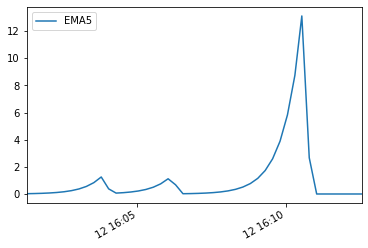

In [17]:
res = influx_df.query(query)
res["activity"].plot()

#### compare ema10 and ema5

In [26]:
# EMA10 has 2 minutes lag, but it is more smooth

table = "activity"
query = f"""
SELECT EXPONENTIAL_MOVING_AVERAGE("sum_activity", 5) AS "EMA5", EXPONENTIAL_MOVING_AVERAGE("sum_activity", 10) AS "EMA10"  
FROM (
SELECT (c_count + k_count+ s_count) AS "sum_activity" FROM "autogen"."{table}" WHERE "sid" =~ /562a49dc/
ORDER BY time DESC LIMIT 50
) 
ORDER BY time DESC
"""
res = influx_df.query(query)
df_task = res[table]

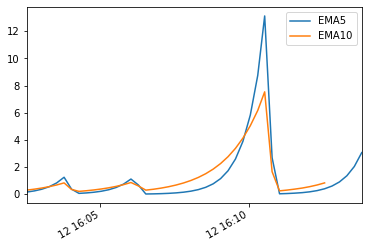

In [27]:
df_task.plot() #lag shown

### Active / Not Active - at this moment

In [28]:
#Query based on EMA5
query = f"""
SELECT EXPONENTIAL_MOVING_AVERAGE("sum_activity", 5) AS "EMA5"
FROM (
    SELECT (c_count + k_count+ s_count) AS "sum_activity" 
    FROM "autogen"."activity" 
    WHERE "sid" =~ /562a49dc/
    ORDER BY time DESC LIMIT 50
) 
ORDER BY time DESC LIMIT 1
"""
res = influx_cnx.query(query)
res

ResultSet({'('activity', None)': [{'time': '2020-06-12T16:14:03Z', 'EMA5': 5.133333333333333}]})

In [29]:
for results in res: 
    for i in results:
        print("Active =", i["EMA5"] > 0.1)

Active = True


### Active / Not Active in last 5 min

In [33]:
#Query
#this one is laging when it comes to NEW activity, depending on GROUP BY TIME (in this example lag of 10s)
#but it shows, if user was active during last 5min
table = "activity"
query = f"""
SELECT COUNT(sum_activity) FROM 
(
    SELECT (c_count + k_count+ s_count) AS "sum_activity" 
    FROM "g_events"."autogen"."{table}" 
    WHERE "sid" =~ /{user_sid}/  
    AND (c_count > 0 OR k_count > 0 OR s_count > 0) 
    ORDER BY time DESC LIMIT 100
) 

GROUP BY time(10s) ORDER BY time DESC LIMIT 30
"""

res = influx_cnx.query(query)

In [34]:
sum_activity = 0
for results in res: 
    for i in results:
        sum_activity += i["count"]
print("Idle :", sum_activity == 0)
print("Active :", sum_activity > 0)

Idle : False
Active : True


### consequtive days/ habit strength

#### Based on task_submit event

In [35]:
# Activity during diff days.Based on task_submit event
query = f"""
SELECT COUNT("eid") AS sum_activity 
FROM "g_events"."autogen"."events" 
WHERE "sid" =~ /{user_sid}/ AND "event" =~/subm/ 
GROUP BY time(1d)
"""
res = influx_df.query(query)
df_task = res["events"]

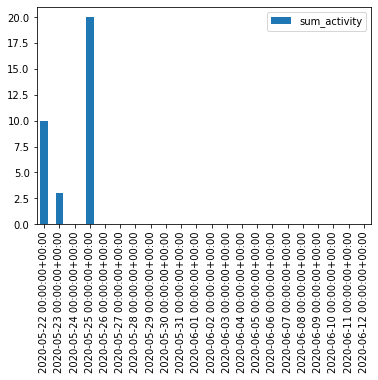

In [36]:
df_task.fillna(0).plot(kind="bar")

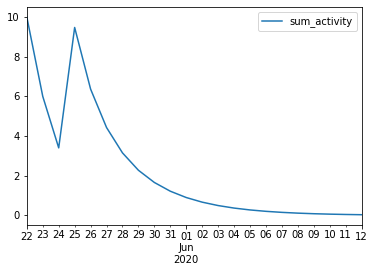

In [42]:
df_task.fillna(0).ewm(span=7).mean().plot(kind="line") #smooth out version

#### Based on "activity" table

In [38]:
# Activity during diff days. Based on "activity" table

query = f"""
SELECT SUM(c_count) + SUM(k_count) + SUM(s_count) AS sum_activity from "g_events"."autogen"."activity" WHERE "sid" =~ /{user_sid}/ group by time(1d)
"""

res = influx_df.query(query)
df_act_sum = res[table]

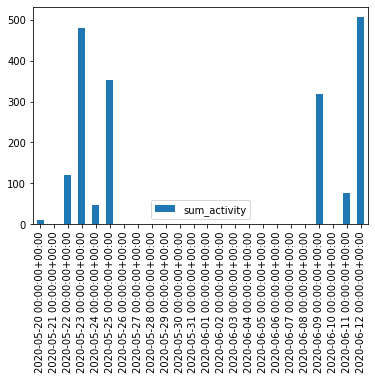

In [39]:
df_act_sum.fillna(0).plot(kind="bar")

/home/sajo/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


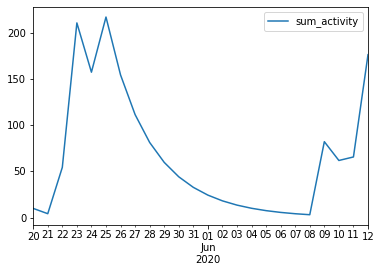

In [41]:
df_act_sum.fillna(0).ewm(span=7).mean().plot(kind="line") #smooth out version

## WIP

### Avg Submit attempts until success

In [43]:
# this sum up ALL-TIME events, later this could be grouped by month/week/day
# or filtered by particular tasks

query1 = f"""
SELECT COUNT("eid") FROM "autogen"."events" WHERE "sid" =~ /{user_sid}/ AND "event" =~/subm/
"""
tasks_submitted = influx_cnx.query(query1)

query2 = f"""
SELECT COUNT("eid") FROM "autogen"."events" WHERE "sid" =~ /{user_sid}/ AND "event" =~/end/
"""
tasks_ended = influx_cnx.query(query2)

In [44]:
for q in tasks_submitted:
    ts = q[0]["count"]
for q in tasks_ended:
    te = q[0]["count"]
    
avg_sub_attepts = ts/te
avg_sub_attepts

8.25

#### using pandas

using pandas, because you can't filter data by fields (eid is an field) in influxdb

In [45]:
query1= f"""
SELECT * FROM "autogen"."events" WHERE "sid" =~ /{user_sid}/ AND "event" =~/subm/
"""
res1 = influx_df.query(query1)
df_task = res1["events"]

In [46]:
df_avg = pd.DataFrame()
df_avg["submitted"] = df_task["eid"].value_counts()

In [47]:
query2 = f"""
SELECT * FROM "autogen"."events" WHERE "sid" =~ /{user_sid}/ AND "event" =~/end/
"""
res2 = influx_df.query(query2)
df_task = res2["events"]
df_avg["finished"] = df_task["eid"].value_counts()

In [48]:
df_avg["avg_per_task"] = df_avg["submitted"]/df_avg["finished"]

In [49]:
df_avg

,submitted,finished,avg_per_task
5b3f8190-0d0e-49f1-8306-d1f27da64c72,9,1.0,9.0
a467eb45-de7c-432d-93fa-b9de76ddeac1,7,1.0,7.0
811a13dc-6636-4a28-8930-68c74fc2dcaa,5,NaN,NaN
d64c91bc-a4fe-4e41-8145-d41055857b8b,4,NaN,NaN
34debe74-4de2-4453-a9c0-d208bc1588b9,4,NaN,NaN
d827f036-befc-4701-b48a-0b9e25e3e24e,3,1.0,3.0
b83a5d3b-80f2-47f0-8424-27087132aba5,1,1.0,1.0


In [50]:
# all submitted vs task finished
df_avg["submitted"].sum()/df_avg["finished"].sum()

8.25

In [51]:
# average for only completed tasks
df_avg.dropna()["submitted"].sum()/df_avg.dropna()["finished"].sum()

5.0

In [52]:
# average for only completed tasks
df_avg.dropna()["submitted"].sum()/df_avg.dropna()["submitted"].count()

5.0

### Progress (inner LP / outer tasks)

## misc queries

shows how many submit events user has

`SELECT COUNT("eid") FROM "autogen"."events" WHERE "sid" =~ /6f4b6/  AND "event" =~/subm/ GROUP BY "event"`

show how many tasks ended user has

`SELECT COUNT("eid") FROM "autogen"."events" WHERE "sid" =~ /6f4b6/  AND "event" =~/end/ GROUP BY "event"`


In [ ]:
print(df_task.fillna(0).ewm(span=7).mean())

In [ ]:
df_task.fillna(0).ewm(span=7).mean().plot()